In [2]:
import pandas as pd
import numpy as np
import pickle
!pip install beautifulsoup4
from bs4 import BeautifulSoup
import unicodedata
from unidecode import unidecode
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords



**METADATA**

In [36]:
# Initialize a counter
ebook_metadata = pd.DataFrame()
chunk_metadata = []

# Iterate over the file in chunks
for chunk in pd.read_json(r'C:\Users\ACER\Downloads\Electronics_5\meta_Electronics.json', lines=True, chunksize=1000):
    matching_rows = chunk[chunk['title'].str.contains('ebook|ebooks', case=False)]
    # Append matching rows to the list
    chunk_metadata.append(matching_rows)
    
ebook_metadata = pd.concat(chunk_metadata, ignore_index=True)

print("Total number of metadata rows with product Ebook(s):", len(ebook_metadata))

asin = ebook_metadata['asin'].to_list()

with open (r'C:\Users\ACER\Downloads\Electronics_5\ebook_metadata.pkl', 'wb') as file:
    pickle.dump(ebook_metadata, file)
    
del ebook_metadata, chunk_metadata

Total number of metadata rows with product Ebook(s): 21723


**DATA**

In [38]:
# Initialize a counter
ebook_data = pd.DataFrame()
chunk_data = []

# Iterate over the file in chunks
for chunk in pd.read_json(r'C:\Users\ACER\Downloads\Electronics_5\Electronics_5.json', lines=True, chunksize=1000):
    matching_rows = chunk[chunk['asin'].isin(asin)]
    # Append matching rows to the list
    chunk_data.append(matching_rows)
    
ebook_data = pd.concat(chunk_data, ignore_index=True)

ebook_data = ebook_data.dropna(axis=0, how='any')
ebook_data.drop_duplicates(subset=['asin'], keep='first')
print("Total number of data rows with product Ebook(s):", len(ebook_data))

with open (r'C:\Users\ACER\Downloads\Electronics_5\ebook_data.pkl', 'wb') as file:
    pickle.dump(ebook_data, file)
    
del ebook_data, chunk_data

Total number of data rows with product Ebook(s): 111153


**LOAD PICKLE**

In [13]:
with open (r'C:\Users\ACER\Downloads\Electronics_5\ebook_metadata.pkl', 'rb') as file:
    ebook_metadata = pickle.load(file)

with open (r'C:\Users\ACER\Downloads\Electronics_5\ebook_data.pkl', 'rb') as file:
    ebook_data = pickle.load(file)
    
ebook_data = ebook_data.dropna(axis=0, how='all', ignore_index=True)

print(ebook_metadata)
print(ebook_data)

                                                category  \
0      [Electronics, Computers &amp; Accessories, Com...   
1      [Electronics, eBook Readers &amp; Accessories,...   
2      [Electronics, eBook Readers &amp; Accessories,...   
3      [Electronics, eBook Readers &amp; Accessories,...   
4      [Electronics, eBook Readers &amp; Accessories,...   
...                                                  ...   
21718  [Electronics, Computers & Accessories, Compute...   
21719  [Electronics, Computers & Accessories, Compute...   
21720  [Electronics, Computers & Accessories, Laptop ...   
21721  [Electronics, Computers & Accessories, Compute...   
21722  [Electronics, eBook Readers & Accessories, eBo...   

                                                   tech1  \
0                                                          
1                                                          
2                                                          
3                                      

**STATISTICS**

In [21]:
print("Number of Reviews: ", len(ebook_data.reviewerID.unique()))
print("Average Rating Score:", ebook_data['overall'].mean(), "/", ebook_data['overall'].max())
print("Number of Unique Products: ", len(ebook_metadata.title.unique()))
print("Number of Good Rating: ", ebook_data[(ebook_data['overall']>=3)].shape[0])
print("Number of Bad Rating: ", ebook_data[(ebook_data['overall']<3)].shape[0])
print("Number of Reviews corresponding to Rating 0: ", ebook_data[(ebook_data['overall']<1)].shape[0])
print("Number of Reviews corresponding to Rating 1: ", ebook_data[(ebook_data['overall']>=1) & (ebook_data['overall']<2)].shape[0])
print("Number of Reviews corresponding to Rating 2: ", ebook_data[(ebook_data['overall']>=2) & (ebook_data['overall']<3)].shape[0])
print("Number of Reviews corresponding to Rating 3: ", ebook_data[(ebook_data['overall']>=3) & (ebook_data['overall']<4)].shape[0])
print("Number of Reviews corresponding to Rating 4: ", ebook_data[(ebook_data['overall']>=4) & (ebook_data['overall']<5)].shape[0])
print("Number of Reviews corresponding to Rating 5: ", ebook_data[(ebook_data['overall']==5)].shape[0])

Number of Reviews:  90653
Average Rating Score: 4.276744667260443 / 5
Number of Unique Products:  21040
Number of Good Rating:  98496
Number of Bad Rating:  12657
Number of Reviews corresponding to Rating 0:  0
Number of Reviews corresponding to Rating 1:  7654
Number of Reviews corresponding to Rating 2:  5003
Number of Reviews corresponding to Rating 3:  8122
Number of Reviews corresponding to Rating 4:  18523
Number of Reviews corresponding to Rating 5:  71851


**PREPROCESSING**

In [14]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
nltk.download('punkt')
stemmer = PorterStemmer()
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

import warnings
warnings.filterwarnings("ignore")

for index in ebook_data.index:
    
    review = ebook_data['reviewText'][index]
    
    # print(review)
    # review = "<html>jsdhcvdɔɪtʃhjsvcuysdvcjhs.,64*dcvjhsdcv</html> rocks, eating"
    # review = "              I am                   eating apples"
    
    try:
        review = review.strip()
    except:
        review = str(review)
        review = review.strip()
    
    review = BeautifulSoup(review, 'lxml').get_text()
    review = unidecode(review)
    
    temp = review
    for char in review:
        if char.isalnum()==False and char.isspace()==False:
            # print(char)
            temp = temp.replace(char, '')
    review = temp

    tokens = word_tokenize(review)
    tokens = [token for token in tokens if token not in stop_words]
    tokens = [stemmer.stem(token) for token in tokens]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    review = ' '.join(tokens)
    
    ebook_data['reviewText'][index] = review
  
for index in ebook_data.index:
    
    review = ebook_data['summary'][index]
    
    # print(review)
    # review = "<html>jsdhcvdɔɪtʃhjsvcuysdvcjhs.,64*dcvjhsdcv</html> rocks, eating"
    # review = "              I am                   eating apples"
    
    try:
        review = review.strip()
    except:
        review = str(review)
        review = review.strip()
    
    review = BeautifulSoup(review, 'lxml').get_text()
    review = unidecode(review)
    
    temp = review
    for char in review:
        if char.isalnum()==False and char.isspace()==False:
            # print(char)
            temp = temp.replace(char, '')
    review = temp

    tokens = word_tokenize(review)
    tokens = [token for token in tokens if token not in stop_words]
    tokens = [stemmer.stem(token) for token in tokens]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    review = ' '.join(tokens)
    
    ebook_data['summary'][index] = review
    


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**EDA STATISTICS**

In [15]:
data = ebook_metadata.merge(ebook_data, on='asin', how='left')
del ebook_data, ebook_metadata

group = data.groupby(by="brand")
print("\033[1m" + "Top 20 most reviewed brands in the category that you have chosen: \n\n" + "\033[0m", group.size().sort_values(ascending=False).head(20))
print("\033[1m" + "\n\nTop 20 least reviewed brands in the category that you have chosen: \n\n" + "\033[0m", group.size().sort_values().head(20))

filtered_data = data[(data['overall']>=3)] 
group = data.groupby(by="title")
print("\033[1m" + "\n\nMost positively reviewed e_book:\n\n" + "\033[0m", group.size().sort_values(ascending=False).head(1)) 

data['reviewTime'] = pd.to_datetime(data['reviewTime'])
print("\033[1m" + "\n\nCount of ratings for Ebook over 5 consecutive years: \n" + "\033[0m")
years = data['reviewTime'].dropna().dt.year.unique().astype(int)
years.sort()
years = years[::-1]
filtered_data = data.dropna(axis=0, subset=['reviewTime'])
print(years[0]," - ", (len(filtered_data[(filtered_data['reviewTime'].dt.year.astype(int) == years[0])])))
print(years[1]," - ", (len(filtered_data[(filtered_data['reviewTime'].dt.year.astype(int) == years[1])])))
print(years[2]," - ", (len(filtered_data[(filtered_data['reviewTime'].dt.year.astype(int) == years[2])])))
print(years[3]," - ", (len(filtered_data[(filtered_data['reviewTime'].dt.year.astype(int) == years[3])])))
print(years[4]," - ", (len(filtered_data[(filtered_data['reviewTime'].dt.year.astype(int) == years[4])])))
print("Total in 5 years - ", (len(filtered_data[(filtered_data['reviewTime'].dt.year.astype(int).isin(years))])))

Top 20 most reviewed brands in the category that you have chosen: 

 brand
Acer           4835
Anker          4415
Crucial        4247
HP             3381
Kingston       3237
Samsung        2899
PWR+           2850
Microsoft      2606
Asus           2557
Targus         2400
Logitech       2385
Evecase        2382
TeckNet        2358
Toshiba        1894
Thermaltake    1707
Dell           1700
Generic        1638
Kensington     1630
Case Logic     1422
LotFancy       1401
dtype: int64


Top 20 least reviewed brands in the category that you have chosen: 

 brand
zorrol                  1
Fujitssu                1
Prohoists               1
Prolynkz                1
Frybrid                 1
Propower                1
Protech                 1
Pushin' The Envelope    1
Friends Equipments      1
Frida Kahlo             1
Primo Tech              1
FreshZone               1
Freelander              1
QIHANG                  1
Free trip               1
QKILL                   1
QLPD              

**WORDCLOUD**



Word Cloud for Good ratings:




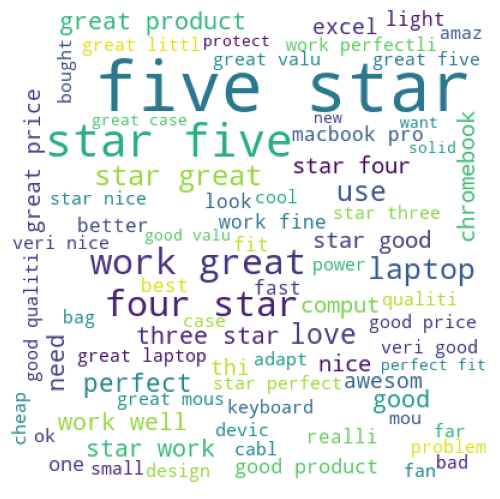



Word Cloud for Bad ratings:




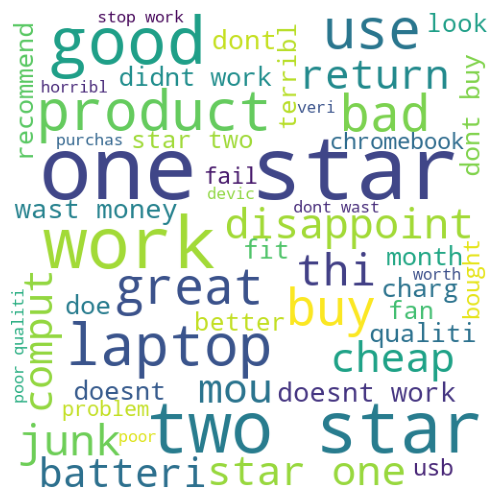

In [16]:
filtered_data = data.dropna(subset=['summary'], axis=0)

with open (r'C:\Users\ACER\Downloads\Electronics_5\ebook_filtered.pkl', 'wb') as file:
    pickle.dump(filtered_data, file)

good = filtered_data[(filtered_data['overall']>=3)]['summary']
bad = filtered_data[(filtered_data['overall']<3)]['summary']

!pip install WordCloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
stopwords = set(STOPWORDS)

good_words = ''
bad_words = ''

for review in good:
    # review = review.astype(string)
    try:
        good_words += " " + review + " "
    except:
        pass

print("\033[1m" + "\n\nWord Cloud for Good ratings:\n\n" + "\033[0m")
good_wordcloud = WordCloud(width = 400, height = 400, background_color ='white', max_words=75, stopwords = stopwords, min_font_size = 10).generate(good_words)

plt.figure(facecolor = None)
plt.imshow(good_wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

for review in bad:
    # review = review.astype(string)
    try:
        bad_words += " " + review + " "
    except:
        pass

print("\033[1m" + "\n\nWord Cloud for Bad ratings:\n\n" + "\033[0m")
bad_wordcloud = WordCloud(width = 500, height = 500, background_color ='white', max_words=50, stopwords = stopwords, min_font_size = 10).generate(bad_words)

plt.figure(facecolor = None)
plt.imshow(bad_wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

**PIE CHART**

Year in which the product got maximum reviews:  2016 (reviews = 24881)
Year in which the product got maximum customers:  2011 (reviewers = 2969)


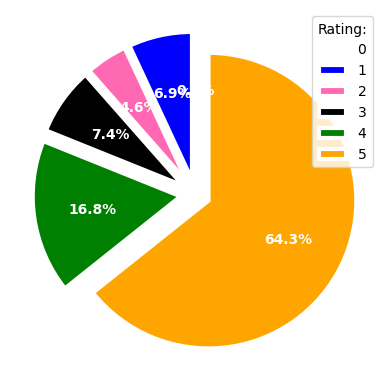

In [8]:
data['reviewTime'] = pd.to_datetime(data['reviewTime'])
years = data['reviewTime'].dropna().dt.year.unique().astype(int)
filtered_data = data.dropna(axis=0, subset=['reviewTime'])
max_yr = None
max_reviews = 0
reviews_per_yr = {}
for i in years:
    num_of_reviews = len(filtered_data[(filtered_data['reviewTime'].dt.year.astype(int) == i)])
    reviews_per_yr[i] = num_of_reviews
    if num_of_reviews > max_reviews:
        max_reviews = num_of_reviews
        max_yr = i
print("\033[1m" + "Year in which the product got maximum reviews: " + "\033[0m", max_yr, f"(reviews = {max_reviews})")

max_yr = None
max_customers = 0
customers_per_yr = {}
for i in years:
    num_of_customers = filtered_data[filtered_data['reviewTime'].dt.year.astype(int) == i]['reviewerID'].nunique()
    customers_per_yr[i] = num_of_customers
    if num_of_reviews > max_customers:
        max_customers = num_of_customers
        max_yr = i
print("\033[1m" + "Year in which the product got maximum customers: " + "\033[0m", max_yr, f"(reviewers = {max_customers})")

distribution = np.array([data[(data['overall']<1)].shape[0], data[(data['overall']>=1) & (data['overall']<2)].shape[0], data[(data['overall']>=2) & (data['overall']<3)].shape[0], data[(data['overall']>=3) & (data['overall']<4)].shape[0], data[(data['overall']>=4) & (data['overall']<5)].shape[0], data[(data['overall']==5)].shape[0]])
labels = [0,1,2,3,4,5]
colors = ['white', 'blue', 'hotpink','black', 'green', 'orange']
explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1) 
plt.pie(distribution, labels = labels, startangle = 90, colors = colors, autopct='%1.1f%%', textprops={'color':"white", 'weight': 'bold'}, wedgeprops={'linewidth': 3, 'edgecolor': 'white'}, explode=explode)
plt.legend(title = "Rating:", loc="upper right")
plt.show()

**FEATURE ENGINEERING** - TF-IDF

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

with open (r'C:\Users\ACER\Downloads\Electronics_5\ebook_filtered.pkl', 'rb') as file:
    filtered_data = pickle.load(file)

corpus = filtered_data['summary'].tolist()
tfidf = TfidfVectorizer()

X = tfidf.fit_transform(corpus)
y = [1 if rating > 3 else 0 if rating == 3 else -1 for rating in filtered_data['overall']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


**MACHINE LEARNING MODELS**

1. SVC

In [5]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model1 = SVC()
model1.fit(X_train, y_train)

y_pred = model1.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.8921575437621562
Precision: 0.8821058706124367
Recall: 0.8921575437621562
F1 Score: 0.8762682169990069


2. RANDOM FOREST

In [6]:
from sklearn.ensemble import RandomForestClassifier

model2 = RandomForestClassifier(random_state=42)
model2.fit(X_train, y_train)

y_pred = model2.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.8966032231175326
Precision: 0.886821595131674
Recall: 0.8966032231175326
F1 Score: 0.8854719697318874


3. NAIVE BAYES

In [7]:
from sklearn.naive_bayes import MultinomialNB

model3 = MultinomialNB()
model3.fit(X_train, y_train)

y_pred = model3.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.8580161155876632
Precision: 0.8545848126072396
Recall: 0.8580161155876632
F1 Score: 0.8252706446820356


4. KNN

In [11]:
from sklearn.neighbors import KNeighborsClassifier

model4 = KNeighborsClassifier()
model4.fit(X_train, y_train)

y_pred = model4.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.8691997777160322
Precision: 0.850887783399006
Recall: 0.8691997777160322
F1 Score: 0.8528242581951095


5. GRADIENT BOOST

In [12]:
from sklearn.ensemble import GradientBoostingClassifier

model5 = GradientBoostingClassifier()
model5.fit(X_train, y_train)

y_pred = model5.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.8619408168935816
Precision: 0.8550318273512264
Recall: 0.8619408168935816
F1 Score: 0.8328422833634189


In [38]:
with open (r'C:\Users\ACER\Downloads\Electronics_5\ebook_filtered.pkl', 'rb') as file:
    filtered_data = pickle.load(file)

In [ ]:
filtered_data = filtered_data.dropna(axis=0, subset=['overall','reviewerID','asin'])

row_indices = filtered_data['asin'].unique()
print(row_indices)
num_rows = len(row_indices)
matrix = pd.DataFrame(index=range(num_rows), columns=[])

for index in filtered_data.index:
    column_name = filtered_data['reviewerID'][index]
    row_index = filtered_data['asin'][index]
    if column_name in matrix.columns:
        try:
            if not pd.isnull(matrix.loc[row_index, column_name]):
                matrix.loc[row_index, column_name] += filtered_data['overall'][index]
            else:
                matrix.loc[row_index, column_name] = filtered_data['overall'][index]
        except:
            print(column_name)
            print(matrix.columns)
    else:
        matrix[column_name] = None
        matrix.loc[row_index, column_name] = filtered_data['overall'][index]
    break


print(matrix.shape)